In [22]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
%matplotlib inline

# 관련 라이브러리 임포트 
import matplotlib.font_manager as fm

#  한글글꼴로 변경
# plt.rcParams['font.family'] = '한글글꼴명'
plt.rcParams['font.size'] = 11.0
# plt.rcParams['font.family'] = 'batang'
plt.rcParams['font.family'] = 'Malgun Gothic'

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
matplotlib.rcParams['axes.unicode_minus'] = False

# 그래프 기본 크기 설정 
plt.rcParams['figure.figsize'] = [10, 6]

## 모델링을 위한 새로운 조건으로 1개 분기만 가지고 해보기로 함

In [2]:
df = pd.read_excel('data/ID있는버전.xlsx')
df.head(5)

,ID,시군구,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,거래유형
0,서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80,서울특별시 강남구 개포동,개포6차우성아파트1동~8동,80,201801,3,130000,4,1987,언주로 3,-
1,서울특별시 동작구 신대방동 롯데관악타워 150,서울특별시 동작구 신대방동,롯데관악타워,150,201801,4,74000,27,1996,보라매로5길 51,-
2,서울특별시 동작구 신대방동 경남교수 80,서울특별시 동작구 신대방동,경남교수,80,201801,25,65000,17,2001,여의대방로10길 14,-
3,서울특별시 동작구 상도동 힐스테이트 상도 프레스티지 80,서울특별시 동작구 상도동,힐스테이트 상도 프레스티지,80,201801,27,85800,15,2013,상도로 346-2,-
4,서울특별시 동작구 상도동 힐스테이트 상도 프레스티지 120,서울특별시 동작구 상도동,힐스테이트 상도 프레스티지,120,201801,24,104500,12,2013,상도로 346-2,-


In [3]:
df['계약년월'] = pd.to_datetime(df['계약년월'], format='%Y%m')
df['분기'], df['년도'] = (df['계약년월'].dt.quarter, df['계약년월'].dt.year)
df['분기'] = df[['년도','분기']].apply(lambda row:'/'.join(row.values.astype(str)), axis=1)
del df['년도']

In [4]:
df.head(5)

,ID,시군구,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,거래유형,분기
0,서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80,서울특별시 강남구 개포동,개포6차우성아파트1동~8동,80,2018-01-01,3,130000,4,1987,언주로 3,-,2018/1
1,서울특별시 동작구 신대방동 롯데관악타워 150,서울특별시 동작구 신대방동,롯데관악타워,150,2018-01-01,4,74000,27,1996,보라매로5길 51,-,2018/1
2,서울특별시 동작구 신대방동 경남교수 80,서울특별시 동작구 신대방동,경남교수,80,2018-01-01,25,65000,17,2001,여의대방로10길 14,-,2018/1
3,서울특별시 동작구 상도동 힐스테이트 상도 프레스티지 80,서울특별시 동작구 상도동,힐스테이트 상도 프레스티지,80,2018-01-01,27,85800,15,2013,상도로 346-2,-,2018/1
4,서울특별시 동작구 상도동 힐스테이트 상도 프레스티지 120,서울특별시 동작구 상도동,힐스테이트 상도 프레스티지,120,2018-01-01,24,104500,12,2013,상도로 346-2,-,2018/1


In [5]:
# 피쳐별로 따로따로 만듬
table1 = pd.pivot_table(df, values=['거래금액(만원)'], index=['분기'], columns=['ID'], aggfunc=np.mean)
table2 = pd.pivot_table(df, values=['전용면적(㎡)'], index=['분기'], columns=['ID'], aggfunc=np.mean)
table3 = pd.pivot_table(df, values=['건축년도'], index=['분기'], columns=['ID'], aggfunc=np.mean)

In [6]:
 # 보스턴 데이터에서 배껴온 널값 지우기 * 3
check_null1 = table1.isna().sum() / 18
check_null2 = table2.isna().sum() / 18
check_null3 = table3.isna().sum() / 18

# columns of null ratio >= 0.5
check_null1[check_null1 >= 0.5]
check_null2[check_null2 >= 0.5]
check_null3[check_null3 >= 0.5]

# remove columns of null ratio >= 0.5
remove_cols1 = check_null1[check_null1 >= 0.5].keys()
remove_cols2 = check_null2[check_null2 >= 0.5].keys()
remove_cols3 = check_null3[check_null3 >= 0.5].keys()

table1 = table1.drop(remove_cols1, axis=1)
table2 = table2.drop(remove_cols2, axis=1)
table3 = table3.drop(remove_cols3, axis=1)

In [7]:
# 결측치채우기 * 3
table1.fillna(method='ffill', inplace=True)
table1.fillna(method='bfill', inplace=True)
table2.fillna(method='ffill', inplace=True)
table2.fillna(method='bfill', inplace=True)
table3.fillna(method='ffill', inplace=True)
table3.fillna(method='bfill', inplace=True)

In [8]:
table1.head(1)

거래금액(만원)                           \
ID     서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80 서울특별시 강남구 개포동 개포주공1단지 40   
분기                                                                
2018/1                        129125.0            145736.842105   

                                                          \
ID     서울특별시 강남구 개포동 개포주공5단지 60 서울특별시 강남구 개포동 개포주공5단지 80   
분기                                                         
2018/1            136666.666667            177416.666667   

                                                          \
ID     서울특별시 강남구 개포동 개포주공6단지 50 서울특별시 강남구 개포동 개포주공6단지 60   
분기                                                         
2018/1                 125900.0                 135200.0   

                                                          \
ID     서울특별시 강남구 개포동 개포주공6단지 70 서울특별시 강남구 개포동 개포주공6단지 80   
분기                                                         
2018/1                 151500.0                 163500.0   

                                                          ...  \
ID     서울특별시 강남구 개포동 개포주공7단지 50 서울특별시 강남구 개포동 개포주공7단지 60  ...   
분기                                                        ...   
2018/1                 120300.0                 134750.0  ...   

                                                            \
ID     서울특별시 중랑구 신내동 화성.두산아파트 70 서울특별시 중랑구 신내동 화성.두산아파트 80   
분기                                                           
2018/1              36777.272727                   40925.0   

                                                                          \
ID     서울특별시 중랑구 중화동 극동 80 서울특별시 중랑구 중화동 동양엔파트 80 서울특별시 중랑구 중화동 범양프레체 20   
분기                                                                         
2018/1             36300.0                44000.0                12200.0   

                                                         \
ID     서울특별시 중랑구 중화동 중화동건영아파트 60 서울특별시 중랑구 중화동 태능에셈빌 80   
분기                                                        
2018/1                   25000.0                35000.0   

                                                                             
ID     서울특별시 중랑구 중화동 한신아파트 50 서울특별시 중랑구 중화동 한신아파트 60 서울특별시 중랑구 중화동 한신아파트 80  
분기                                                                           
2018/1               31756.25           36534.615385           45081.176471  

[1 rows x 4163 columns]

In [9]:
# 행열 바꾸기 * 3
data1 = table1.transpose()
data2 = table2.transpose()
data3 = table3.transpose()

In [10]:
# 멀티인덱스 지우기 * 3
money = data1.droplevel(axis=0, level=0)
width = data2.droplevel(axis=0, level=0)
year = data3.droplevel(axis=0, level=0)
money.iloc[:,0:1]

분기,2018/1
ID,
서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80,129125.000000
서울특별시 강남구 개포동 개포주공1단지 40,145736.842105
서울특별시 강남구 개포동 개포주공5단지 60,136666.666667
서울특별시 강남구 개포동 개포주공5단지 80,177416.666667
서울특별시 강남구 개포동 개포주공6단지 50,125900.000000
...,...
서울특별시 중랑구 중화동 중화동건영아파트 60,25000.000000
서울특별시 중랑구 중화동 태능에셈빌 80,35000.000000
서울특별시 중랑구 중화동 한신아파트 50,31756.250000


In [11]:
# 다시 합치기
data = pd.concat([money.iloc[:,0:1],width.iloc[:,0:1],year.iloc[:,0:1]], axis=1)
data.columns = ['거래금액(만원)','전용면적','건축년도']
data = data.round(1)

In [12]:
# 라벨분리
x = data.iloc[:,1:3]
y = data.iloc[:,0:1]
x

,전용면적,건축년도
ID,,
서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80,80.0,1987.0
서울특별시 강남구 개포동 개포주공1단지 40,40.0,1982.0
서울특별시 강남구 개포동 개포주공5단지 60,60.0,1983.0
서울특별시 강남구 개포동 개포주공5단지 80,80.0,1983.0
서울특별시 강남구 개포동 개포주공6단지 50,50.0,1983.0
...,...,...
서울특별시 중랑구 중화동 중화동건영아파트 60,60.0,1998.0
서울특별시 중랑구 중화동 태능에셈빌 80,80.0,2005.0
서울특별시 중랑구 중화동 한신아파트 50,50.0,1997.0


In [13]:
# 스케일링
mm = MinMaxScaler()
mm_scaled = mm.fit_transform(x)
samples = pd.DataFrame(mm_scaled)

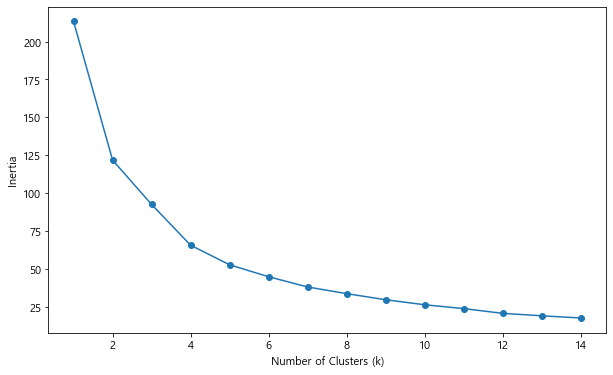

In [14]:
# 최적의 k값 찾기-배껴온 코드
num_clusters = list(range(1, 15))	# K는 1 ~ 8사이의 정수입니다
inertias = []
# 각 K별로 모델을 생성하여 inertia를 측정합니다
for i in num_clusters:
    model = KMeans(n_clusters=i)
    model.fit(samples)
    inertias.append(model.inertia_)
# K에 따른 inertia의 변화를 시각화합니다
plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [15]:
# KMeans-랜덤시드고정
kmeans = KMeans(n_clusters=6, random_state=0)
clusters = kmeans.fit(mm_scaled)

x['cluster'] = clusters.labels_
x.head(5)

,전용면적,건축년도,cluster
ID,,,
서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80,80.0,1987.0,2
서울특별시 강남구 개포동 개포주공1단지 40,40.0,1982.0,2
서울특별시 강남구 개포동 개포주공5단지 60,60.0,1983.0,2
서울특별시 강남구 개포동 개포주공5단지 80,80.0,1983.0,2
서울특별시 강남구 개포동 개포주공6단지 50,50.0,1983.0,2


c:\Users\2005-009\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


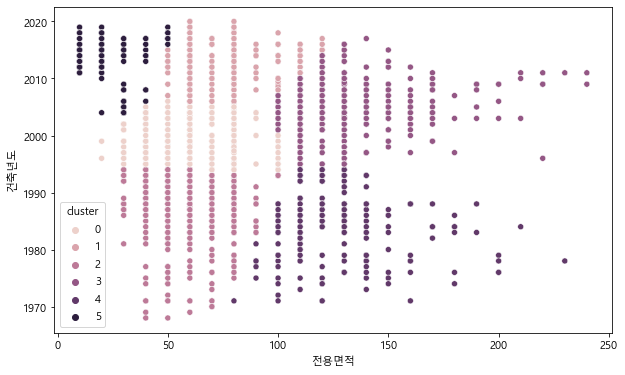

In [18]:
# 시각화-경고는 왜나오는지 모르겠음
axs = plt.subplot()
axs = sns.scatterplot('전용면적','건축년도',hue='cluster', data=x);

In [19]:
# 이하 거래금액을 포함시킨후 시행
# 스케일링
mm = MinMaxScaler()
mm_scaled = mm.fit_transform(data)
samples = pd.DataFrame(mm_scaled)

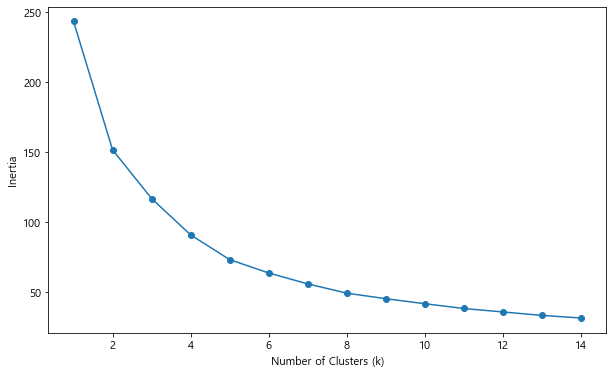

In [20]:
# 최적의 k값 찾기-배껴온 코드
num_clusters = list(range(1, 15))	# K는 1 ~ 8사이의 정수입니다
inertias = []
# 각 K별로 모델을 생성하여 inertia를 측정합니다
for i in num_clusters:
    model = KMeans(n_clusters=i)
    model.fit(samples)
    inertias.append(model.inertia_)
# K에 따른 inertia의 변화를 시각화합니다
plt.plot(num_clusters, inertias, '-o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [34]:
# KMeans-랜덤시드고정
kmeans = KMeans(n_clusters=5, random_state=0)
clusters = kmeans.fit(mm_scaled)

data['cluster'] = clusters.labels_
data.head(5)

,거래금액(만원),전용면적,건축년도,cluster
ID,,,,
서울특별시 강남구 개포동 개포6차우성아파트1동~8동 80,129125.0,80.0,1987.0,0
서울특별시 강남구 개포동 개포주공1단지 40,145736.8,40.0,1982.0,0
서울특별시 강남구 개포동 개포주공5단지 60,136666.7,60.0,1983.0,0
서울특별시 강남구 개포동 개포주공5단지 80,177416.7,80.0,1983.0,4
서울특별시 강남구 개포동 개포주공6단지 50,125900.0,50.0,1983.0,0


In [35]:
# 거래금액을 포함했기 때문에 차원수를 다시 2로 줄일 필요가 있음
X = mm_scaled.copy()
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
x_pca

array([[ 0.25030077,  0.04251226],
       [ 0.33316295, -0.10524586],
       [ 0.32045504, -0.03426292],
       ...,
       [ 0.04483574, -0.13574308],
       [ 0.04649287, -0.09336791],
       [ 0.04976982, -0.00943019]])

In [39]:
# 차원수를 줄인 결과
pca_df = pd.DataFrame(x_pca)
pca_df['cluster'] = x['cluster'].values
pca_df.head()

,0,1,cluster
0,0.250301,0.042512,0
1,0.333163,-0.105246,0
2,0.320455,-0.034263,0
3,0.328755,0.075276,4
4,0.316660,-0.081303,0


c:\Users\2005-009\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


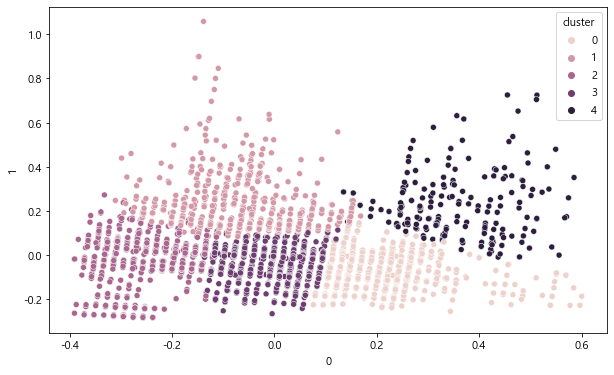

In [40]:
# 시각화-경고는 왜나오는지 모르겠음
axs = plt.subplot()
axs = sns.scatterplot(0,1,hue='cluster', data=pca_df);

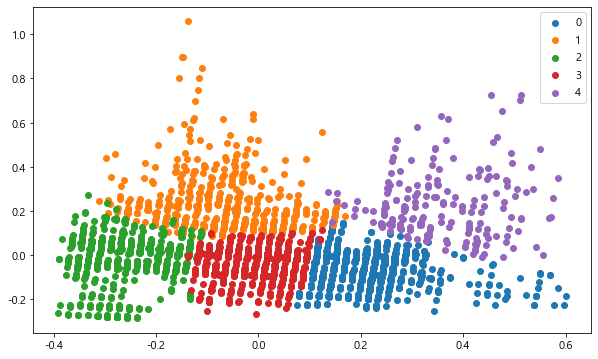

In [41]:
# 위의 그래프와 방식만 다르고 같음
for i in sorted(pca_df['cluster'].unique()):
    tmp = pca_df.loc[pca_df['cluster'] == i]
    plt.scatter(tmp[0], tmp[1])
    plt.legend(sorted(pca_df['cluster'].unique()));